## Data Port Landuse

In [1]:
import geopandas as gpd

# Load the GeoPackage
port_landuse = gpd.read_file("port_landuse.gpkg")

# Display the first few rows
port_landuse.head()

,port_name,country,continent,area,type,sector,land_use,geometry
0,Whittier,U.S.A.,North-America,491304.083136,mixed,Transport,General Cargo,"POLYGON ((-148.68538 60.77793, -148.68341 60.7..."
1,Vancouver,Canada,North-America,37384.673004,mixed,Transport,General Cargo,"POLYGON ((-122.8957 49.29054, -122.89482 49.29..."
2,Rotterdam,Netherlands,Western-Europe,552124.737468,mixed,Transport,General Cargo,"POLYGON ((4.04439 51.96173, 4.04661 51.96607, ..."
3,Rotterdam,Netherlands,Western-Europe,674482.110351,mixed,Transport,General Cargo,"POLYGON ((4.28683 51.89551, 4.28713 51.89596, ..."
4,Rotterdam,Netherlands,Western-Europe,289595.849762,mixed,Transport,General Cargo,"POLYGON ((4.41177 51.88397, 4.41237 51.88512, ..."


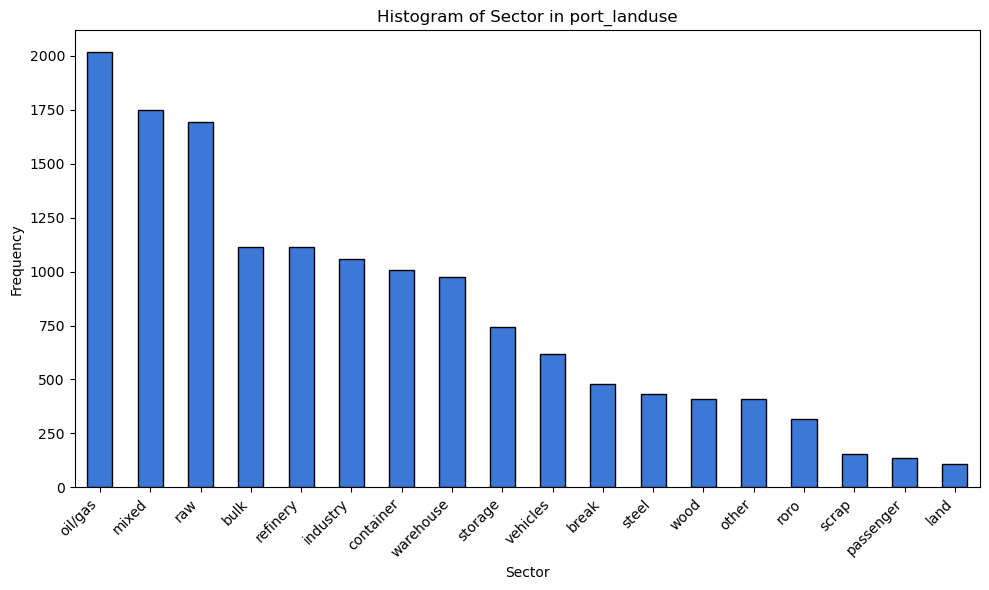

In [2]:
import matplotlib.pyplot as plt

# Count the occurrences of each sector
sector_counts = port_landuse['type'].value_counts()

# Plot the histogram as a bar chart
plt.figure(figsize=(10, 6))
sector_counts.plot(kind='bar', color='#3C78D8', edgecolor='black')
plt.xlabel('Sector')
plt.ylabel('Frequency')
plt.title('Histogram of Sector in port_landuse')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd

# Load the CSV file into a DataFrame
port_silo = pd.read_csv("port_silo.csv")

# Display the first few rows
display(port_silo)

,port_name,country,continent,area,silo_name,silo_id,silo_lon,silo_lat
0,Prince Rupert,U.S.A.,North-America,71838.339836,Prince Rupert_Silo_1,silo_1,-130.344754,54.305965
1,Vancouver,Canada,North-America,937433.440907,Vancouver_Silo_1,silo_2,-123.119249,49.312548
2,Vancouver,Canada,North-America,304749.586921,Vancouver_Silo_2,silo_3,-123.108554,49.313308
3,Vancouver,U.S.A.,North-America,406569.480183,Vancouver_Silo_3,silo_4,-122.703510,45.637562
4,Portland,U.S.A.,North-America,361493.961891,Portland_Silo_1,silo_5,-122.773238,45.601908
...,...,...,...,...,...,...,...,...
1109,Port of Can Tho,Vietnam,Asia,62041.177185,Port of Can Tho_Silo_2,silo_1110,105.707529,10.109612
1110,Port of Can Tho,Vietnam,Asia,66199.748812,Port of Can Tho_Silo_3,silo_1111,105.705683,10.111212
1111,Port of Can Tho,Vietnam,Asia,86586.511066,Port of Can Tho_Silo_4,silo_1112,105.690073,10.122597
1112,Astrakhan Port,Russia,Eastern-Europe,142637.718645,Astrakhan Port_Silo_1,silo_1113,48.019634,46.376855


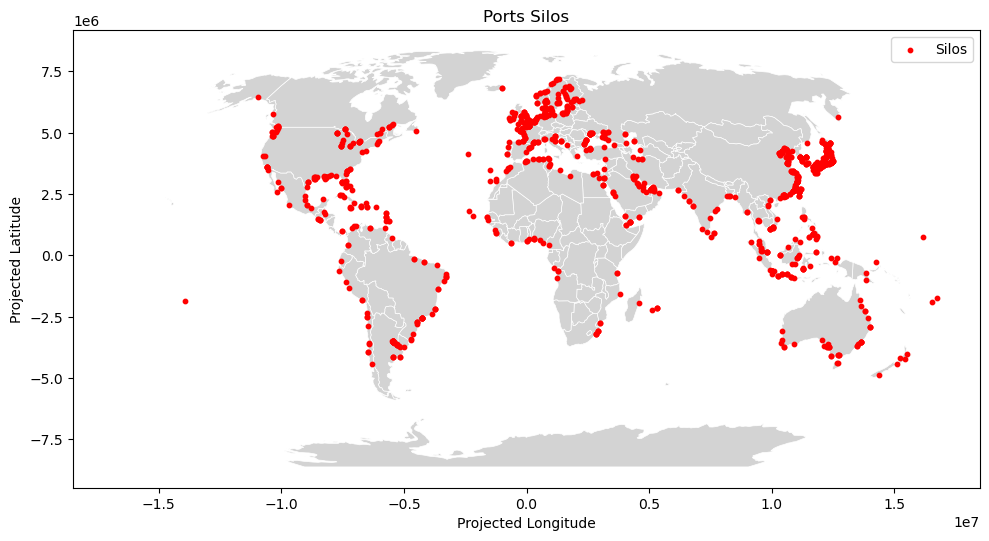

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import geopandas as gpd
from pyproj import Transformer

def robinson_pandas(port_df, port_lat, port_lon, download_folder="natural_earth"):
    # URL for Natural Earth Admin 0 (countries) data
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    shapefile_name = "ne_110m_admin_0_countries.shp"
    shapefile_path = os.path.join(download_folder, shapefile_name)
    
    # Download and extract the shapefile if it does not exist
    if not os.path.exists(shapefile_path):
        os.makedirs(download_folder, exist_ok=True)
        response = requests.get(url)
        with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
            zf.extractall(download_folder)
    
    # Load the Natural Earth shapefile
    world = gpd.read_file(shapefile_path)
    
    # Reproject world data to Robinson projection (ESRI:54030)
    world_rob = world.to_crs("ESRI:54030")
    
    # Create the base plot for the world map
    fig, ax = plt.subplots(figsize=(10, 6))
    world_rob.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.5)
    
    # Create a transformer from EPSG:4326 (WGS84) to ESRI:54030 (Robinson)
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:54030", always_xy=True)
    
    # Apply transformation row-by-row and store results in new columns
    transformed = port_df.apply(lambda row: transformer.transform(row[port_lon], row[port_lat]), axis=1)
    port_df["proj_lon"] = transformed.apply(lambda t: t[0])
    port_df["proj_lat"] = transformed.apply(lambda t: t[1])
    
    # Plot the transformed port points as red dots
    ax.scatter(port_df["proj_lon"], port_df["proj_lat"], color='red', marker='o', s=10, label="Silos")
    
    ax.set_title("Ports Silos")
    ax.set_xlabel("Projected Longitude")
    ax.set_ylabel("Projected Latitude")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    return fig, ax

# Example usage:
# Assuming 'port_silo' is your pandas DataFrame with columns 'silo_lat' and 'silo_lon'
fig, ax = robinson_pandas(port_silo, "silo_lat", "silo_lon")


## SILO to PORT MATCHING

In [6]:
all_ports_file = 'all_ports.csv'
all_ports_df = pd.read_csv(all_ports_file)

In [7]:
import math
import pandas as pd

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points 
    on the Earth (specified in decimal degrees) using the Haversine formula.
    Returns distance in kilometers.
    """
    R = 6371  # Earth's radius in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

results = []
# Iterate over each silo in port_silo
for idx, silo in port_silo.iterrows():
    silo_lat = silo['silo_lat']
    silo_lon = silo['silo_lon']
    min_distance = float('inf')
    closest_port = None
    
    # Compare with every port in all_ports_df
    for jdx, port in all_ports_df.iterrows():
        port_lat = port['port_lat']
        port_lon = port['port_lon']
        distance = haversine_distance(silo_lat, silo_lon, port_lat, port_lon)
        
        if distance < min_distance:
            min_distance = distance
            closest_port = port
            
    results.append({
        'silo_id': silo['silo_id'],
        'silo_name': silo['silo_name'],
        'closest_port_id': closest_port['port_id'],
        'closest_port_name': closest_port['port_name'],
        'distance_km': min_distance
    })

# Create the new dataframe with the matching results
silo_port_match = pd.DataFrame(results)


In [8]:
unique_closest_ports = silo_port_match[['closest_port_id', 'closest_port_name']].drop_duplicates(subset=['closest_port_id']).reset_index(drop=True)
display(unique_closest_ports)

,closest_port_id,closest_port_name
0,port1021,Prince Rupert_U.S.A.
1,port1350,Vancouver_Canada
2,port1351,Vancouver_U.S.A.
3,port993,Portland_U.S.A.
4,port664,Los Angeles_U.S.A.
...,...,...
592,port43,Amirabad Port_Iran
593,port834,Nowshahr Port_Iran
594,port58,Anzali Port_Iran
595,port983,Port of Can Tho_Vietnam


## Filter Out Relevant Ships

In [10]:
portcalls_final_file = 'portcalls_final.csv'
portcalls_final_df = pd.read_csv(portcalls_final_file)
print("Port Calls Data loaded successfully:")
display(portcalls_final_df)

Port Calls Data loaded successfully:


,portid,portname,country,ISO3,imo,mmsi,vessel_type,dtg_in,dtg_out,draught_in,...,trade_to_adjust,export_avg,import_avg,trade_has_adjusted,not_draught_out_adj,trade_not_adjusted_and_no_bp,export_2e_avg,import_2e_avg,import,export
0,port101,Balboa,Panama,PAN,9101455.0,356470000.0,Tanker,2019-01-01 00:00:00,2019-01-03 22:02:09,4.5,...,False,0.000000,0.000000,False,False,False,0.0,0.0,0.000000,349.344646
1,port1308,Tomakomai,Japan,JPN,9347140.0,372041000.0,Cargo,2019-01-01 00:00:00,2019-01-07 08:03:08,5.6,...,False,0.000000,0.000000,False,False,False,0.0,0.0,2095.519100,0.000000
2,port787,Nakhodka,Russian Federation,RUS,8674819.0,667001649.0,Cargo,2019-01-01 00:00:00,2019-01-05 15:03:09,3.9,...,True,2438.903036,0.000000,True,False,False,0.0,0.0,0.000000,2438.903036
3,port208,Caleta Patillos,Chile,CHL,9403164.0,353554000.0,Cargo,2019-01-01 00:00:00,2019-01-04 08:09:20,11.8,...,False,0.000000,0.000000,False,False,False,0.0,0.0,0.000000,6101.642875
4,port619,La Libertad,Ecuador,ECU,9398591.0,735059140.0,Tanker,2019-01-01 00:00:01,2019-01-05 03:00:34,4.6,...,True,1358.263358,607.840036,True,False,False,0.0,0.0,607.840036,1358.263358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9275865,port1062,Penang,Malaysia,MYS,9925461.0,352001081.0,Tanker,2024-10-15 18:18:45,2024-10-15 23:24:04,6.0,...,True,163.142974,1031.660227,True,True,False,0.0,0.0,1031.660227,163.142974
9275866,port73,Ashdod,Israel,ISR,9354428.0,255805686.0,Cargo,2024-10-15 18:23:48,2024-10-15 23:24:41,8.1,...,True,262.867032,773.048520,True,True,False,0.0,0.0,773.048520,262.867032
9275867,port275,Dammam,Saudi Arabia,SAU,9660542.0,403518000.0,Cargo,2024-10-15 18:34:37,2024-10-15 23:37:18,12.9,...,True,83.370583,29036.233754,True,True,False,0.0,0.0,29036.233754,83.370583
9275868,port1376,Vyborg,Russian Federation,RUS,9296547.0,256096000.0,Tanker,2024-10-15 21:38:51,2024-10-15 23:23:25,5.0,...,False,0.000000,0.000000,False,True,False,0.0,0.0,0.000000,2509.640030


In [15]:
# -------------------------------------------------------------------------
# Vessel Data Analysis
# -------------------------------------------------------------------------
vessels_file = 'vessels.csv'
vessels_df = pd.read_csv(vessels_file)
print("Data loaded successfully into vessels_df:")
display(vessels_df)

Data loaded successfully into vessels_df:


,mmsi,imo,NAME,TYPE_SUMMARY,VESSEL_TYPE,dwt,draught_design,length_design,width_design,UPDATE_DATETIME,block
0,1,8209119,DOKKEN 1,Tanker,OIL/CHEMICAL TANKER,12964.0,8.80,127.00,23.00,NaN,0.82
1,1,8216679,HARI SAGAR,Tanker,OIL PRODUCTS TANKER,7335.0,7.02,114.10,16.80,NaN,0.82
2,1,8839471,SATYA BERJAYA,Cargo,GENERAL CARGO,1046.0,4.40,67.00,10.00,2022-06-13 10:08:31.303,0.72
3,1,9351335,VRIDO II,Cargo,INLAND CARGO,NaN,NaN,86.00,12.00,2022-12-26 10:07:15.273,NaN
4,2,8683846,OCEAN 2,Tanker,WATER TANKER,474.0,NaN,NaN,NaN,NaN,0.72
...,...,...,...,...,...,...,...,...,...,...,...
81003,1056498552,9763631,MOUNT ASO,Cargo,BULK CARRIER,36766.0,10.37,183.00,29.50,2022-11-21 10:09:34.963,0.81
81004,1057097027,9849655,DEL MONTE ROSE,Cargo,CONTAINER SHIP,26500.0,10.90,192.00,30.00,2021-10-25 10:05:56.640,0.67
81005,1057097040,9730878,CABO FUJI,Tanker,OIL PRODUCTS TANKER,74246.0,14.45,228.00,32.24,2021-08-02 10:06:01.123,0.84
81006,1059037250,7349651,AL BADRI 1,Cargo,LIVESTOCK CARRIER,1580.0,5.60,80.00,13.00,2022-01-11 11:59:18.583,0.72


In [16]:
# Filter vessels_df to keep only rows where VESSEL_TYPE is one of the specified types
grain_vessels_df = vessels_df[vessels_df['VESSEL_TYPE'].isin([
    'BULK CARRIER', 'GENERAL CARGO', 'CONTAINER SHIP'
])].copy()

# Display the first few rows to verify the filtering
grain_vessels_df

,mmsi,imo,NAME,TYPE_SUMMARY,VESSEL_TYPE,dwt,draught_design,length_design,width_design,UPDATE_DATETIME,block
2,1,8839471,SATYA BERJAYA,Cargo,GENERAL CARGO,1046.0,4.40,67.00,10.00,2022-06-13 10:08:31.303,0.72
7,5,9118941,MORETA CARGO 1,Cargo,GENERAL CARGO,1475.0,3.66,80.22,12.73,2023-08-01 15:41:06.900,0.72
9,13,9672222,DAIWAN CHAMPION,Cargo,BULK CARRIER,34393.0,9.82,179.96,30.00,2023-06-26 10:06:22.093,0.81
10,14,9055981,FU ZHOU HAI,Cargo,BULK CARRIER,69967.0,13.60,225.00,32.20,NaN,0.83
11,22,9189938,OCEANA SKY,Cargo,GENERAL CARGO,50655.0,12.23,194.94,32.24,2022-03-28 10:07:45.820,0.83
...,...,...,...,...,...,...,...,...,...,...,...
81001,1030292642,9356311,CMA CGM MUSCA,Cargo,CONTAINER SHIP,131830.0,15.52,347.00,45.20,2021-04-05 10:03:08.597,0.67
81002,1056044152,9721073,CL TERESA,Cargo,BULK CARRIER,63606.0,13.30,199.90,NaN,2022-11-21 10:09:34.963,0.83
81003,1056498552,9763631,MOUNT ASO,Cargo,BULK CARRIER,36766.0,10.37,183.00,29.50,2022-11-21 10:09:34.963,0.81
81004,1057097027,9849655,DEL MONTE ROSE,Cargo,CONTAINER SHIP,26500.0,10.90,192.00,30.00,2021-10-25 10:05:56.640,0.67


In [17]:
# Filter vessels based on design dimensions
filtered_vessels_df = grain_vessels_df[
    (grain_vessels_df['length_design'] >= 129) & (grain_vessels_df['length_design'] <= 295) &
    (grain_vessels_df['width_design'] >= 20) & (grain_vessels_df['width_design'] <= 33) &
    (grain_vessels_df['draught_design'] >= 9) & (grain_vessels_df['draught_design'] <= 13)
]

# Drop duplicates based on mmsi, imo, and NAME
filtered_vessels_df = filtered_vessels_df.drop_duplicates(subset=["mmsi", "imo", "NAME"]).copy()

# Display the filtered and deduplicated DataFrame
display(filtered_vessels_df)

,mmsi,imo,NAME,TYPE_SUMMARY,VESSEL_TYPE,dwt,draught_design,length_design,width_design,UPDATE_DATETIME,block
9,13,9672222,DAIWAN CHAMPION,Cargo,BULK CARRIER,34393.0,9.82,179.96,30.00,2023-06-26 10:06:22.093,0.81
11,22,9189938,OCEANA SKY,Cargo,GENERAL CARGO,50655.0,12.23,194.94,32.24,2022-03-28 10:07:45.820,0.83
35,1235,9734733,SHANDONG FU HUI,Cargo,BULK CARRIER,81782.0,12.20,229.00,32.26,2022-08-08 10:06:28.360,0.88
61,568032,8302193,ADMAS,Cargo,GENERAL CARGO,13593.0,9.14,149.15,22.01,NaN,0.76
66,1098536,9335458,VINALINES MIGHTY,Cargo,BULK CARRIER,22500.0,9.52,153.20,26.00,2021-07-26 10:05:28.390,0.81
...,...,...,...,...,...,...,...,...,...,...,...
80950,890919912,7426215,JEANNIE III,Cargo,BULK CARRIER,34537.0,10.89,180.02,28.45,NaN,0.81
80973,990000000,8919568,TAI SHUN HAI,Cargo,BULK CARRIER,47378.0,11.70,189.94,32.20,2021-10-04 10:09:04.293,0.81
80983,999999999,8406286,ELONA,Cargo,CONTAINER SHIP,40859.0,11.53,269.67,32.29,2023-09-25 10:06:12.530,0.76
81003,1056498552,9763631,MOUNT ASO,Cargo,BULK CARRIER,36766.0,10.37,183.00,29.50,2022-11-21 10:09:34.963,0.81


In [18]:
import pandas as pd

# Step 1: Filter portcalls_final_df by portid
filtered_portcalls = portcalls_final_df[portcalls_final_df['portid'].isin(unique_closest_ports['closest_port_id'])]

# Step 2: Count how many times each mmsi appears in the filtered portcalls
mmsi_counts = filtered_portcalls['mmsi'].value_counts().reset_index()
mmsi_counts.columns = ['mmsi', 'frequency']

# Step 3: Limit to only mmsi present in filtered_vessels_df
filtered_mmsi = set(filtered_vessels_df['mmsi'].unique())
vessels_frequent = mmsi_counts[mmsi_counts['mmsi'].isin(filtered_mmsi)].reset_index(drop=True)

# Display the new DataFrame
vessels_frequent


,mmsi,frequency
0,416438000.0,994
1,416337000.0,939
2,416047000.0,898
3,416488000.0,891
4,413695760.0,888
...,...,...
11673,255805684.0,1
11674,525100289.0,1
11675,574004820.0,1
11676,371408000.0,1


In [19]:
# Merge vessels_frequent with filtered_vessels_df to get the vessel type information
merged_df = pd.merge(vessels_frequent, 
                     filtered_vessels_df[['mmsi', 'VESSEL_TYPE']], 
                     on='mmsi', 
                     how='left')

# Calculate the percentage distribution of vessel types among the vessels in vessels_frequent
vessel_type_percentages = merged_df['VESSEL_TYPE'].value_counts(normalize=True) * 100

# Print the percentages rounded to 2 decimals
print(vessel_type_percentages.round(2))


VESSEL_TYPE
BULK CARRIER      64.71
CONTAINER SHIP    25.61
GENERAL CARGO      9.68
Name: proportion, dtype: float64


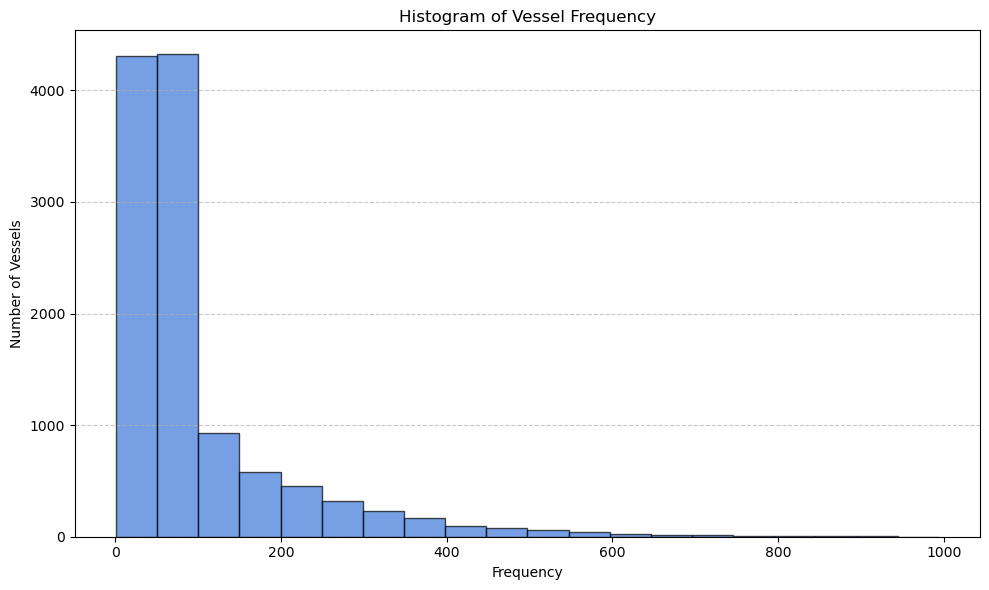

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(vessels_frequent['frequency'], bins=20, color='#3C78D8', edgecolor='black', alpha=0.7)
plt.xlabel("Frequency")
plt.ylabel("Number of Vessels")
plt.title("Histogram of Vessel Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [21]:
vessels_frequent = vessels_frequent[vessels_frequent['frequency'] >= 300].copy()
display(vessels_frequent)

,mmsi,frequency
0,416438000.0,994
1,416337000.0,939
2,416047000.0,898
3,416488000.0,891
4,413695760.0,888
...,...,...
740,413334000.0,300
741,352254000.0,300
742,255805922.0,300
743,636020254.0,300


In [22]:
# Merge vessels_frequent with filtered_vessels_df to get the vessel type information
merged_df = pd.merge(vessels_frequent, 
                     filtered_vessels_df[['mmsi', 'VESSEL_TYPE']], 
                     on='mmsi', 
                     how='left')

# Calculate the percentage distribution of vessel types among the vessels in vessels_frequent
vessel_type_percentages = merged_df['VESSEL_TYPE'].value_counts(normalize=True) * 100

# Print the percentages rounded to 2 decimals
print(vessel_type_percentages.round(2))


VESSEL_TYPE
CONTAINER SHIP    92.36
BULK CARRIER       6.72
GENERAL CARGO      0.92
Name: proportion, dtype: float64


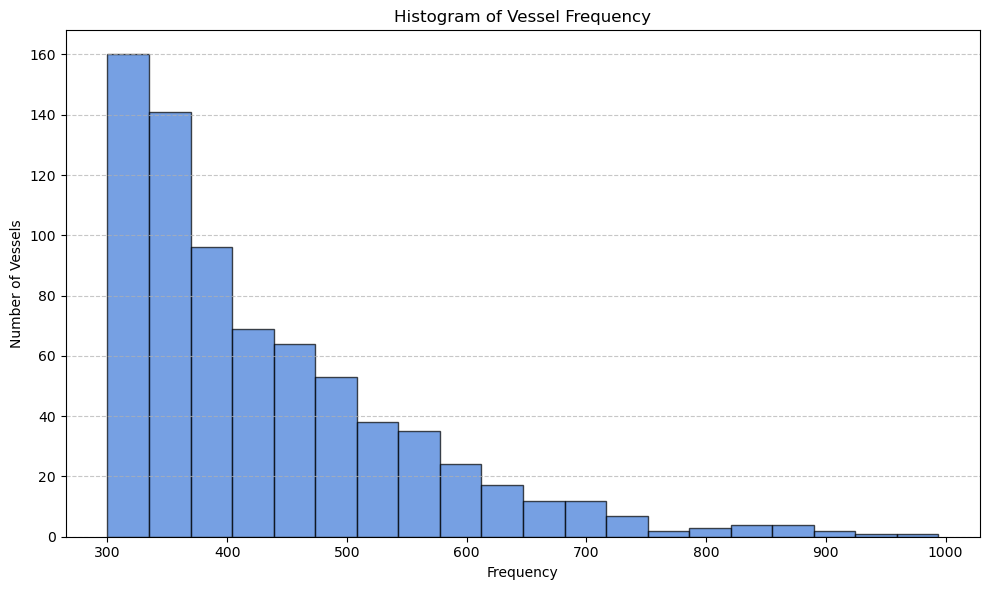

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(vessels_frequent['frequency'], bins=20, color='#3C78D8', edgecolor='black', alpha=0.7)
plt.xlabel("Frequency")
plt.ylabel("Number of Vessels")
plt.title("Histogram of Vessel Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd

# 1. Filter vessels_frequent for vessels with frequency > 200
high_freq_threshold = 200
vessels_high_freq = vessels_frequent[vessels_frequent['frequency'] > high_freq_threshold].copy()

# 2. Optionally, merge with filtered_vessels_df to get more vessel details (like name, type, etc.)
vessels_high_freq_details = pd.merge(
    vessels_high_freq,
    filtered_vessels_df,  # The DataFrame that has extra vessel columns
    on='mmsi',
    how='left'
)

# 3. Inspect the top 10 vessels by frequency
top_10_vessels = vessels_high_freq_details.nlargest(10, 'frequency')

print("=== Vessels with Frequency > 200 ===")
print(vessels_high_freq_details[['mmsi', 'frequency', 'NAME', 'VESSEL_TYPE']].head(20))

print("\n=== Top 10 Vessels by Frequency ===")
print(top_10_vessels[['mmsi', 'frequency', 'NAME', 'VESSEL_TYPE']])


=== Vessels with Frequency > 200 ===
           mmsi  frequency             NAME     VESSEL_TYPE
0   416438000.0        994    KANWAY GLOBAL  CONTAINER SHIP
1   416337000.0        939      WAN HAI 235  CONTAINER SHIP
2   416047000.0        898      WAN HAI 232  CONTAINER SHIP
3   416488000.0        891        YM IDEALS  CONTAINER SHIP
4   413695760.0        888  DONG FANG QIANG  CONTAINER SHIP
5   477314300.0        877    XINDE KEELUNG  CONTAINER SHIP
6   353066000.0        870          QIYUNHE  CONTAINER SHIP
7   311000629.0        859          KUO LIN  CONTAINER SHIP
8   565777000.0        833      WAN HAI 317  CONTAINER SHIP
9   477884200.0        831         KUO LONG  CONTAINER SHIP
10  636012796.0        824         YM IMAGE  CONTAINER SHIP
11  371002000.0        821   EASLINE DALIAN  CONTAINER SHIP
12  636013121.0        811   YM IMPROVEMENT  CONTAINER SHIP
13  477225300.0        797      WAN HAI 172  CONTAINER SHIP
14  636012797.0        793    YM INITIATIVE  CONTAINER SHIP
15 

## CREATE AN INITIAL GRAIN NETWORK

In [34]:
maritime_data_file = 'maritime_data.csv'
    
maritime_data_df = pd.read_csv(maritime_data_file)

In [35]:
maritime_data_df

,from_name,to_name,from_id,to_id,from_iso3,to_iso3,distance,transit_hours,transit_days,capacity_daily,from_lat,from_lon,to_lat,to_lon,distance_haversine,to_continent,from_continent
0,Abbot Point_Australia,Abidjan_Cote d'Ivoire,port0,port4,AUS,CIV,20939.388486,523.484712,21.811863,67.985721,-19.893755,148.077620,5.283956,-4.010908,16587.605952,AFRI,AUST
1,Abbot Point_Australia,Acajutla_El Salvador,port0,port6,AUS,SLV,15891.115016,397.277875,16.553245,78.453797,-19.893755,148.077620,13.575440,-89.829672,13836.766791,NOAM,AUST
2,Abbot Point_Australia,Ash Shariqah_United Arab Emirates,port0,port72,AUS,ARE,12286.590187,307.164755,12.798531,83.138699,-19.893755,148.077620,25.363127,55.376233,11198.228266,ASIA,AUST
3,Abbot Point_Australia,Bahia Quintero (Ventanas)_Chile,port0,port90,AUS,CHL,16443.843851,411.096096,17.129004,33.300538,-19.893755,148.077620,-32.766963,-71.483951,12807.101031,SOAM,AUST
4,Abbot Point_Australia,Balikpapa_Indonesia,port0,port102,AUS,IDN,5151.210453,128.780261,5.365844,50.930584,-19.893755,148.077620,-1.202534,116.795980,3985.936418,ASIA,AUST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155516,rada Punta Arenas_Chile,Tauranga_New Zealand,port1432,port1278,CHL,NZL,13413.431301,335.335783,13.972324,73.266565,-53.130331,-70.867852,-37.660488,176.184633,8042.316986,AUST,SOAM
155517,rada Punta Arenas_Chile,Ulsan_South Korea,port1432,port1338,CHL,KOR,21024.686180,525.617155,21.900715,148.330629,-53.130331,-70.867852,35.486473,129.378084,17494.865630,ASIA,SOAM
155518,rada Punta Arenas_Chile,Whangerei_New Zealand,port1432,port1393,CHL,NZL,13377.990291,334.449757,13.935407,48.316730,-53.130331,-70.867852,-35.842383,174.488189,8294.592562,AUST,SOAM
155519,rada Punta Arenas_Chile,Zhapu_China,port1432,port1427,CHL,CHN,22180.417591,554.510440,23.104602,92.602235,-53.130331,-70.867852,30.636885,121.156883,17331.570791,ASIA,SOAM


In [36]:
# Create a set of valid port IDs from unique_closest_ports
valid_port_ids = set(unique_closest_ports['closest_port_id'])

# Filter maritime_data_df to only keep rows where both from_id and to_id are in valid_port_ids
grain_maritime = maritime_data_df[
    maritime_data_df['from_id'].isin(valid_port_ids) &
    maritime_data_df['to_id'].isin(valid_port_ids)
].copy()

# Display the first few rows of the new DataFrame
print(grain_maritime.head())

          from_name                to_name from_id    to_id from_iso3 to_iso3  \
148  Abenra_Denmark         Alborg_Denmark   port1   port29       DNK     DNK   
151  Abenra_Denmark  Amsterdam_Netherlands   port1   port45       DNK     NLD   
152  Abenra_Denmark        Antwerp_Belgium   port1   port57       DNK     BEL   
154  Abenra_Denmark          Arhus_Denmark   port1   port67       DNK     DNK   
155  Abenra_Denmark     Baton Rouge_U.S.A.   port1  port126       DNK     USA   

         distance  transit_hours  transit_days  capacity_daily   from_lat  \
148    587.885036      14.697126      0.612380      332.951173  55.042542   
151   1371.012371      34.275309      1.428138        5.862286  55.042542   
152   1477.093409      36.927335      1.538639      152.965668  55.042542   
154    352.334291       8.808357      0.367015       72.941896  55.042542   
155  12897.073798     322.426845     13.434452      124.832630  55.042542   

     from_lon     to_lat     to_lon  distance_have

In [37]:
grain_maritime

,from_name,to_name,from_id,to_id,from_iso3,to_iso3,distance,transit_hours,transit_days,capacity_daily,from_lat,from_lon,to_lat,to_lon,distance_haversine,to_continent,from_continent
148,Abenra_Denmark,Alborg_Denmark,port1,port29,DNK,DNK,587.885036,14.697126,0.612380,332.951173,55.042542,9.428137,57.054413,9.991279,226.424706,EURO,EURO
151,Abenra_Denmark,Amsterdam_Netherlands,port1,port45,DNK,NLD,1371.012371,34.275309,1.428138,5.862286,55.042542,9.428137,52.410362,4.819634,421.242633,EURO,EURO
152,Abenra_Denmark,Antwerp_Belgium,port1,port57,DNK,BEL,1477.093409,36.927335,1.538639,152.965668,55.042542,9.428137,51.279355,4.317802,539.315651,EURO,EURO
154,Abenra_Denmark,Arhus_Denmark,port1,port67,DNK,DNK,352.334291,8.808357,0.367015,72.941896,55.042542,9.428137,56.151135,10.229251,133.146791,EURO,EURO
155,Abenra_Denmark,Baton Rouge_U.S.A.,port1,port126,DNK,USA,12897.073798,322.426845,13.434452,124.832630,55.042542,9.428137,30.437047,-91.206323,7905.227876,NOAM,EURO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155305,Zhoushan_China,Yatsushiro Ko_Japan,port1429,port1411,CHN,JPN,1761.840154,44.046004,1.835250,6.178082,30.056350,122.100837,32.523436,130.553676,848.448115,ASIA,ASIA
155307,Zhoushan_China,Yingkou_China,port1429,port1415,CHN,CHN,1977.048484,49.426212,2.059426,1927.782420,30.056350,122.100837,40.726890,122.042971,1186.521337,ASIA,ASIA
155308,Zhoushan_China,Yokkaichi_Japan,port1429,port1416,CHN,JPN,3024.623315,75.615583,3.150649,118.180243,30.056350,122.100837,34.971349,136.656308,1468.319333,ASIA,ASIA
155309,Zhoushan_China,Yokohama Ko_Japan,port1429,port1417,CHN,JPN,2623.341945,65.583549,2.732648,206.990685,30.056350,122.100837,35.427556,139.668812,1745.222521,ASIA,ASIA


In [38]:
import networkx as nx

# Option 1: Include all other columns as edge attributes
grain_graph = nx.from_pandas_edgelist(
    grain_maritime,
    source='from_id',
    target='to_id',
    edge_attr=True,  # This will include all columns except the source and target
    create_using=nx.DiGraph()
)

# Option 2: Specify a subset of edge attributes
edge_attributes = [
    'distance', 'transit_hours', 'transit_days', 'capacity_daily',
    'distance_haversine', 'from_iso3', 'to_iso3', 'to_continent', 'from_continent'
]
grain_graph = nx.from_pandas_edgelist(
    grain_maritime,
    source='from_id',
    target='to_id',
    edge_attr=edge_attributes,
    create_using=nx.DiGraph()
)

# Print basic information about the graph
print("Number of nodes:", grain_graph.number_of_nodes())
print("Number of edges:", grain_graph.number_of_edges())


Number of nodes: 596
Number of edges: 52614


In [39]:
import networkx as nx
import pandas as pd

# Compute PageRank for each node in the graph using 'capacity_daily' as the edge weight.
page_rank = nx.pagerank(grain_graph, weight='capacity_daily')

# Convert the PageRank dictionary to a DataFrame
pr_df = pd.DataFrame(list(page_rank.items()), columns=['port_id', 'pagerank'])

# Merge with the ports DataFrame to add the port name.
# (Assuming all_ports_df has columns 'port_id' and 'port_name')
pr_df = pr_df.merge(all_ports_df[['port_id', 'port_name']], on='port_id', how='left')

# Sort by PageRank value in descending order to see the top nodes
pr_df_sorted = pr_df.sort_values(by='pagerank', ascending=False)

pr_df_sorted


,port_id,pagerank,port_name
53,port1201,0.032493,Singapore_Singapore
176,port1188,0.030680,Shanghai_China
153,port824,0.018138,Ningbo_China
3,port57,0.017178,Antwerp_Belgium
96,port1065,0.016095,Pusan_South Korea
...,...,...,...
565,port1380,0.000262,Wallaroo_Australia
569,port152,0.000261,Blanglancang_Indonesia
461,port352,0.000260,Founchon_U.S.A.
594,port695,0.000260,Manitowoc_U.S.A.
